<a href="https://colab.research.google.com/github/harshitarathod2/SoC_diveintotheworldofquant/blob/main/210110090_harshitarathod_momentumeffect_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Momentum

Momentum-based Trading is based on the assumption that Stocks which have performed will in the past, will perform better in the coming future.

To define 'past', we take a variable **N**, and say that :

<centre> Momentum(For A particular stock) = Close Price(Today) - Close Price(N-day ago) </centre>

This gives us our first hyper-parameter (parameters of the model which could be changed in order to improve the model) : **N**

We would also be reshuffling our [Portfolio](https://www.investopedia.com/terms/p/portfolio.asp) at certain intervals of time, which gives us our second hyper-parameter: **T** (The time after which we'll be reshuffling our Portfolio)

Its never suggested to keep all your money invested, you must have some risk-free assets as well, so that even if you lose some of your cash in trading, you could still place better bets and regain that lost cash, Thus, We get our third Hyper-parameter: **R**, The Ratio of Total Balance, which we will using for investing.

You will not be investing in all the 30 Tickers now, Will you? You will choose the top few stocks, which show the highest promise in terms of Momentum, which brings us to another hyper-parameter: **M**, The Number of Top few stocks (based on Momentum), which you'll keep in your Portfolio.

Finally, There's some brokerage fee which you need to pay in order to place orders on the stock market, typically its less than 0.05% of the total amount : **F**


In [ ]:
#Importing Required Libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

#Declaring the Hyperparameters

N = 50
T = 7
R = 0.8
M = 5
F = 0.0005   # 0.5% Brokerage fee

The Second step would be to define a function which reads the Prices of various Stocks into memory.

In the file DATA.csv , which we had uploaded in our repository, we have prices of 30 firms enlisted in S & P 500 Index (Apple, IBM, Cisco, Walmart and the like!) from 2nd January 2009 to 17th August 2020.

For our purposes, We'll only be requiring certain columns. On an honest note, Just getting the Columns on Ticker, Date and Adjusted Closing Price would do the job, but if you want, you may take Opening Price as well.

Read up about the [pandas.read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) function from here, and figure out how you'll use it to do the job (You don't need all the columns!)

In [20]:




def GetData(NameOfFile):
    # Specify the columns to read
    columns_to_read = ['tic', 'datadate', 'adjcp', 'open']

    # Use pandas.read_csv to read the file with selected columns
    data = pd.read_csv(NameOfFile, usecols=columns_to_read)

    return data  # pd.DataFrame Object

To aid Data-Manipulation, it would be beneficial, if we split the DataFrame into many small parts each corresponding to the data corresponding to the 30 Tickers on a particular date. These small parts could then be stored in a list.

We would also be needing to remember which date is at what index, so that we can use that later.

In [22]:
def PartitionData(Data):
    DateToIndex = {}
    DataPartitioned = []

    # Group the data by Date
    grouped_data = Data.groupby('datadate')

    # Iterate over each unique date and create partitions
    for index, (date, group) in enumerate(grouped_data):
        DateToIndex[date] = index
        DataPartitioned.append(group)

    return DataPartitioned, DateToIndex


Now, We need a function to calculate the Momentum value for all of our 30 Tickers.
To do this, We need to have a few things in mind:


1.   We need to start at Nth day in our list, as only then we'll be able to calculate the Momentum (This will be taken care of by later parts of the Program, when we actually run the Model)

2.   The Stock Market isn't open on all days, so we often won't be able to go N days behind, and will have to take the closest value instead(We can't just go N entries behind in the List we created and expect that to work, Why?) In order to work with dates, you should get to know more about the datetime library of Python from [here](https://thispointer.com/python-how-to-convert-datetime-object-to-string-using-datetime-strftime/) (Especially the datetime.strftime() function) and about the [datetime.timedelta()](https://www.studytonight.com/python-howtos/how-to-add-days-to-date-in-python) function.

Also, as you may have figured it out yourself, while DataFrames are great for Data Handling and small statistical calculations, They aren't so for big calculations as the Numpy Library has both a richer variety of functions for such manipulations and is also more efficient!

After we calculate the Momentum for all our Tickers, it would be a great thing to do, if we could divide their prices by their mean(in the N day interval, as we need to see which stock outperforms others and in order to do this, it won't be fair if we take the absolute growth in numbers!(Why?)



In [60]:
import numpy as np
import datetime

def GetMomentumBasedPriority(PartitionedDataFrameList, DateToIndex,year, month, day, N):
    # Convert today's date to a datetime.date() object
    today_date = datetime.date(year,month,day)

    # Calculate the date N days ago
    NdaysAgo = today_date + datetime.timedelta(days=-N)
    NdaysAgo_str = NdaysAgo.strftime('%Y%m%d')

    # Check if N days ago date exists in the data, if not, find the closest date
    if NdaysAgo_str not in DateToIndex:
        dates = [datetime.datetime.strptime(date, '%Y%m%d').date() for date in DateToIndex.keys()]
        closest_date = min(dates, key=lambda date: abs(date - NdaysAgo))
        NdaysAgo_str = closest_date.strftime('%Y%m%d')

    # Calculate the momentum for each ticker and store it in a list
    momentum_values = []
    for ticker_data in PartitionedDataFrameList:
        ticker_data_NdaysAgo = ticker_data[ticker_data['datadate'] == NdaysAgo_str]
        ticker_data_today = ticker_data[ticker_data['datadate'] == today]

        if len(ticker_data_NdaysAgo) == 0 or len(ticker_data_today) == 0:
            momentum_values.append(np.nan)
        else:
            momentum = ticker_data_today['adjcp'].values[0] - ticker_data_NdaysAgo['adjcp'].values[0]
            momentum_values.append(momentum)

    # Convert the list of momentum values to a numpy array
    momentum_values = np.array(momentum_values)

    # Calculate the mean for each ticker in the N-day period
    mean_values = np.array([ticker_data['adjcp'].mean() for ticker_data in PartitionedDataFrameList])

    # Calculate momentum divided by mean for each ticker
    momentum_divided_by_mean = momentum_values / mean_values

    return momentum_divided_by_mean






Even after you have got your Momentum-based priorities, and have decided which stocks to buy and what will be the weight of each, you still need to figure out how much of each will you buy. To do this, first you'll sell all your pre-owned stocks which will increase your cash in hand, then you'll know the stocks to buy and their relative weights (given by their Momentum/mean) and you need a function which tells you how many stocks to buy for each ticker!

In [24]:
import numpy as np

def GetBalanced(prices, weights, balance):
    # Calculate the total investment amount based on the given balance
    total_investment = balance * weights.sum()

    # Calculate the target investment amount for each stock
    target_investment_per_stock = total_investment / len(prices)

    # Calculate the number of shares to buy for each stock
    shares_to_buy = np.floor(target_investment_per_stock / prices)

    # Calculate the actual investment amount for each stock based on the number of shares
    actual_investment = shares_to_buy * prices

    # Calculate the total actual investment
    total_actual_investment = actual_investment.sum()

    # Adjust the number of shares to buy to match the available balance
    while total_actual_investment > balance:
        shares_to_buy -= 1
        actual_investment = shares_to_buy * prices
        total_actual_investment = actual_investment.sum()

    return shares_to_buy







Now, We need something to simulate our [Portfolio](https://www.investopedia.com/terms/p/portfolio.asp). In order to do that we need a class, which has certain  basic features and functionalities.

Features :


1.   Your Initial Balance
2.   Your Current Balance
3.   A list(/any other container) storing the number of stocks of each ticker currently in possession. (Numpy Array prefered)
4.   Most recent prices of all the stocks (As a Numpy array)

Functionalities:



1.   Calculating current Net Worth (Balance+Total Evaluation of all Stocks owned!)
2.   Buying a Particular Stock (Keep the Transaction fee in mind!)
3.   Selling a particular Stock whole (Keep the Transaction Fee in mind!)
4.   Rebalance Portfolio  (Takes Numpy array as input)
5.   Function to change the value of most recent prices stored (Takes Numpy array as input)





In [25]:
import numpy as np

class Portfolio:
    def __init__(self, initial_balance, num_stocks):
        self.initial_balance = initial_balance
        self.current_balance = initial_balance
        self.num_stocks = np.array(num_stocks)
        self.prices = None

    def SellStock(self, index, transaction_fee=0.01):
        num_shares = self.num_stocks[index]
        stock_price = self.prices[index]
        total_sell_amount = num_shares * stock_price
        transaction_cost = total_sell_amount * transaction_fee

        self.current_balance += total_sell_amount - transaction_cost
        self.num_stocks[index] = 0

    def BuyStock(self, index, number, transaction_fee=0.01):
        stock_price = self.prices[index]
        total_buy_amount = number * stock_price
        transaction_cost = total_buy_amount * transaction_fee

        if self.current_balance >= total_buy_amount + transaction_cost:
            self.current_balance -= total_buy_amount + transaction_cost
            self.num_stocks[index] += number

    def CalculateNetWorth(self):
        stock_values = self.num_stocks * self.prices
        net_worth = self.current_balance + stock_values.sum()
        return net_worth

    def ChangePricesTo(self, newPriceVector):
        self.prices = np.array(newPriceVector)

    def RebalancePortFolio(self, newWeights):
        # Sell all pre-owned stocks
        for i in range(len(self.num_stocks)):
            self.SellStock(i)

        # Get the top M stocks based on the newWeights
        M = len(newWeights)
        top_M_stocks_indices = np.argsort(newWeights)[-M:]

        # Buy stocks based on the newWeights
        for index in top_M_stocks_indices:
            weight = newWeights[index]
            number_of_shares = self.GetBalancedShares(index, weight)
            self.BuyStock(index, number_of_shares)

    def GetBalancedShares(self, index, weight):
        total_investment = weight * self.current_balance
        stock_price = self.prices[index]
        return np.floor(total_investment / stock_price)








With that the difficult part is over!

Now, all you need to work on is a main loop, which calls all these functions

In [61]:
N = 50
T = 7
R = 0.8
M = 5
F = 0.0005   # 0.5% Brokerage fee

# Initialize Portfolio object with the specified initial balance and an array of zeros for the number of stocks
myPortfolio = Portfolio(R, np.zeros(30))
NetWorthAfterEachTrade = []

# First Get the Data
Data = GetData("DATA.csv")

# Partition the data
PartitionedData, DateToIndex = PartitionData(Data)

# Start processing from the (N+1)th Day (among the ones recorded in the Data)
for i in range(50, len(PartitionedData)):
    # Change the Prices to the ith Term
    myPortfolio.ChangePricesTo(PartitionedData[i]['adjcp'].values)

    # Get NetWorth and store it in the list
    net_worth = myPortfolio.CalculateNetWorth()
    NetWorthAfterEachTrade.append(net_worth)

    # Check if you need to rebalance the Portfolio today
    if (i - 50) % 7 == 0:
        # Get the date for today from the DataFrame's index (which is the 'datadate')
        today_date = pd.to_datetime(PartitionedData[i]['datadate'].values[0])

        # Calculate momentum-based priorities
        momentum_values = GetMomentumBasedPriority(PartitionedData, DateToIndex, today_date.year, today_date.month, today_date.day, 50)

        # Rebalance Portfolio by passing the new weights
        myPortfolio.RebalancePortFolio(momentum_values)

# Return the answer (NetWorthAfterEachTrade)
NetWorthAfterEachTrade














TypeError: ignored

##Moment of Truth

Time to check, if your Program actually works!

Plot the data you collected in various ways and see if what you did worked!

Feel free to use whichever one of Matplotlib or Seaborn you want to.

You should try changing the hyper-parameters to increase(/decrease) your performance!


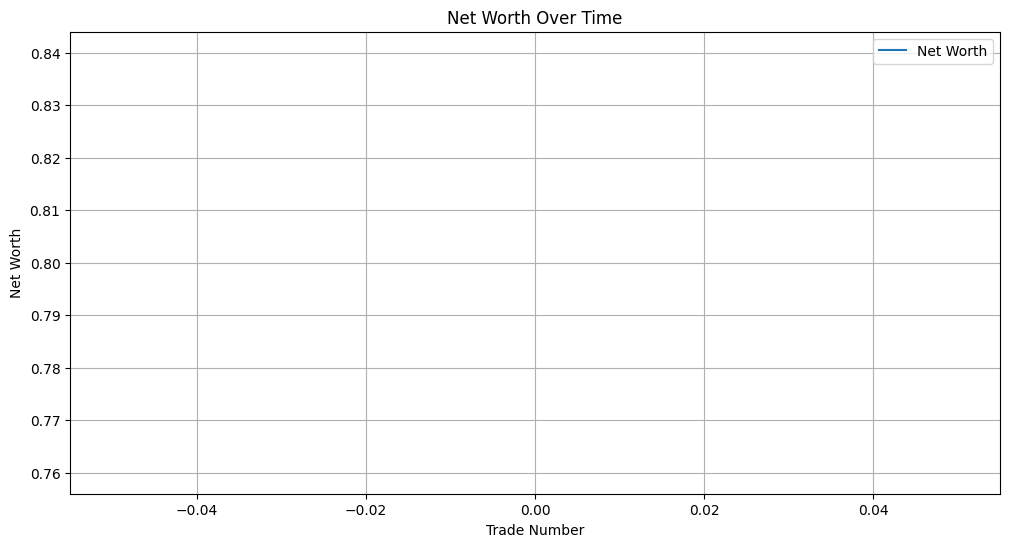

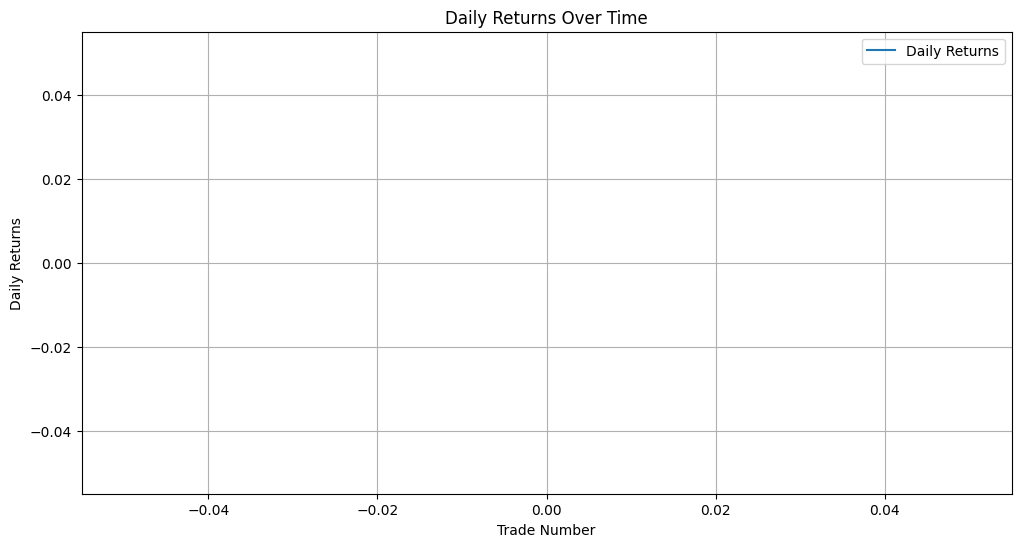

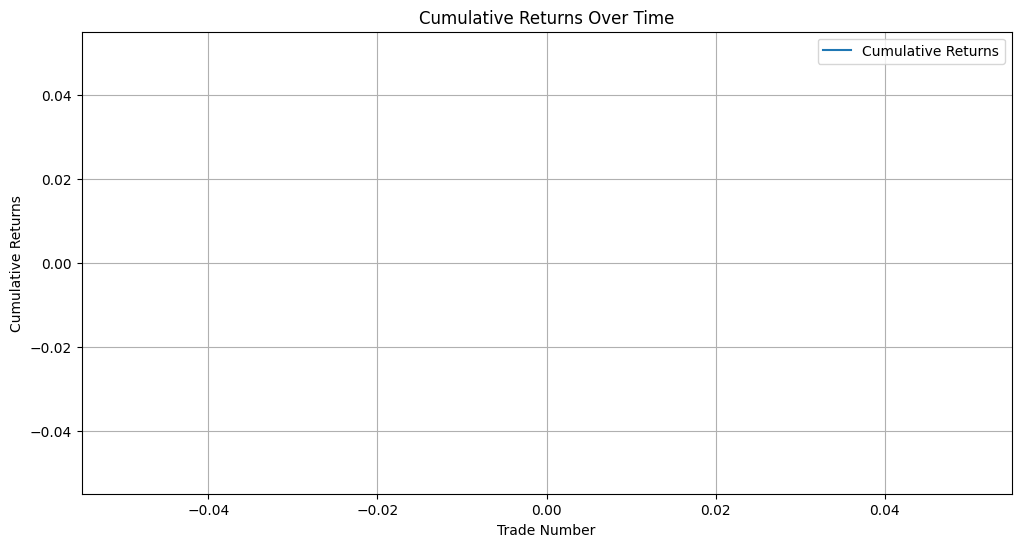

In [41]:

 import matplotlib.pyplot as plt

def VizualizeData(NetWorthAfterEachTrade):
    # Plotting Net Worth Over Time
    plt.figure(figsize=(12, 6))
    plt.plot(NetWorthAfterEachTrade, label='Net Worth')
    plt.xlabel('Trade Number')
    plt.ylabel('Net Worth')
    plt.title('Net Worth Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plotting Daily Returns
    daily_returns = np.diff(NetWorthAfterEachTrade) / NetWorthAfterEachTrade[:-1]
    plt.figure(figsize=(12, 6))
    plt.plot(daily_returns, label='Daily Returns')
    plt.xlabel('Trade Number')
    plt.ylabel('Daily Returns')
    plt.title('Daily Returns Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plotting Cumulative Returns
    cumulative_returns = NetWorthAfterEachTrade / NetWorthAfterEachTrade[0] - 1
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_returns, label='Cumulative Returns')
    plt.xlabel('Trade Number')
    plt.ylabel('Cumulative Returns')
    plt.title('Cumulative Returns Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming you already ran the simulation and obtained the NetWorthAfterEachTrade data
VizualizeData(NetWorthAfterEachTrade)













You may use this cell to write about what results you got!